In [10]:
#seeding for comparing experiment in part 2
import torch
import json
SEED = 2011
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:4')

# SNLI Bert
## Second Tutorial
https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db
Check his Github code for complete notebook. I never referred to it. Medium was enough.
BERT in keras-tf: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b

In [11]:
# define macros
BERT_MODEL = 'bert-base-german-cased'

batch_size = 4
batches_per_epoch = 541

save_path_suffix = '19geluconfig_pooler_features_identity_dropout_double_distance_fix4_lr=1e-6_seed=2011_'

# Prepare data

## load the dataset

In [12]:
import pandas as pd

# custom reader needed to handle quotechars
def read_df_custom(file):
    header = 'doc     unit1_toks      unit2_toks      unit1_txt       unit2_txt       s1_toks s2_toks unit1_sent      unit2_sent      dir     nuc_children    sat_children    genre   u1_discontinuous        u2_discontinuous       u1_issent        u2_issent       u1_length       u2_length       length_ratio    u1_speaker      u2_speaker      same_speaker    u1_func u1_pos  u1_depdir       u2_func u2_pos  u2_depdir       doclen  u1_position      u2_position     percent_distance        distance        lex_overlap_words       lex_overlap_length      unit1_case      unit2_case      label'
    extracted_columns = ['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label', 'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case', 'unit2_case',
                            'u1_discontinuous', 'u2_discontinuous', 'same_speaker', 'lex_overlap_length', 'u1_func']
    header = header.split()
    df = pd.DataFrame(columns=extracted_columns)
    file = open(file, 'r')

    rows = []
    count = 0 
    for line in file:
        line = line[:-1].split('\t')
        count+=1
        if count ==1: continue
        row = {}
        for column in extracted_columns:
            index = header.index(column)
            row[column] = line[index]
        rows.append(row)

    df = pd.concat([df, pd.DataFrame.from_records(rows)])
    return df

train_df = read_df_custom('../../processed/deu.rst.pcc_train_enriched.rels')
test_df = read_df_custom('../../processed/deu.rst.pcc_test_enriched.rels')
val_df = read_df_custom('../../processed/deu.rst.pcc_dev_enriched.rels')
lang = 'deu'

## Clean the data

In [13]:
#dropping any empty values
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Prepare a dataset handler class

In [5]:
train_df.head()

,unit1_txt,unit1_sent,unit2_txt,unit2_sent,dir,label,distance,u1_depdir,u2_depdir,u2_func,...,sat_children,nuc_children,genre,unit1_case,unit2_case,u1_discontinuous,u2_discontinuous,same_speaker,lex_overlap_length,u1_func
0,Dagmar Ziegler sitzt in der Schuldenfalle .,Dagmar Ziegler sitzt in der Schuldenfalle .,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,interpretation,2,ROOT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,root
1,Auf Grund der dramatischen Kassenlage in Brand...,Auf Grund der dramatischen Kassenlage in Brand...,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,1>2,cause,1,RIGHT,ROOT,root,...,0,4,news,cap_initial,other,False,False,True,0,obl
2,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,Der Rückzieher der Finanzministerin ist aber v...,Der Rückzieher der Finanzministerin ist aber v...,1>2,evaluation-n,4,ROOT,ROOT,root,...,4,3,news,other,cap_initial,False,False,True,0,root
3,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"und vorgeschlagen , erst 2003 darüber zu entsc...",Auf Grund der dramatischen Kassenlage in Brand...,1<2,conjunction,1,ROOT,LEFT,conj,...,0,4,news,other,other,False,False,True,0,root
4,hat sie jetzt eine seit mehr als einem Jahr er...,Auf Grund der dramatischen Kassenlage in Brand...,"Überraschend ,","Überraschend , weil das Finanz- und das Bildun...",1<2,interpretation,2,ROOT,ROOT,root,...,1,4,news,other,title,False,False,True,0,root


In [6]:
train_df.columns

Index(['unit1_txt', 'unit1_sent', 'unit2_txt', 'unit2_sent', 'dir', 'label',
       'distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position',
       'u2_position', 'sat_children', 'nuc_children', 'genre', 'unit1_case',
       'unit2_case', 'u1_discontinuous', 'u2_discontinuous', 'same_speaker',
       'lex_overlap_length', 'u1_func'],
      dtype='object')

In [23]:
def remove_classes_not_in_test(train_df, val_df, test_df):
    test_labels = list(test_df['label'].unique())
    train_df = train_df[train_df['label'].isin(test_labels)]
    val_df = val_df[val_df['label'].isin(test_labels)]
    return train_df, val_df, test_df

train_df, val_df, test_df = remove_classes_not_in_test(train_df, val_df, test_df)

# feats

In [24]:
from multiprocessing.sharedctypes import Value
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sys import path
path.append('/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/allennlp/data/data_loaders/')
from allennlp.data import allennlp_collate
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import pandas as pd

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df, test_df):
    self.lang = lang
    self.num_labels = set()
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.test_data = None
    self.train_idx = None
    self.val_idx = None
    self.test_idx = None
    self.init_data()

  def init_data(self):
    self.get_label_mapping()
    self.get_feature_mappings()
    self.set_feature_list()
    self.train_data, self.train_idx = self.load_data(self.train_df)
    self.val_data, self.val_idx = self.load_data(self.val_df)
    self.test_data, self.test_idx = self.load_data(self.test_df)
    self.calculate_unique_values()

  def combine_unique_column_values_to_dict(self, column_name):
    ini_set = set([*self.train_df[column_name].unique(), *self.test_df[column_name].unique(), *self.val_df[column_name].unique()])
    res = dict.fromkeys(ini_set, 0)
    return res

  def get_label_mapping(self):
    labels = {}
    labels_list = list(set(list(self.train_df['label'].unique()) + list(self.test_df['label'].unique()) + list(self.val_df['label'].unique())))
    for i in range(len(labels_list)):
        labels[labels_list[i]] = i
    self.label_dict = labels
    # needed later for classification report object to generate precision and recall on test dataset
    self.rev_label_dict = {self.label_dict[k]:k for k in self.label_dict.keys()} 

  def get_feature_mappings(self):
    self.feature_maps = { 'genre': self.combine_unique_column_values_to_dict('genre'),
                          'unit1_case': self.combine_unique_column_values_to_dict('unit1_case'),
                          'unit2_case': self.combine_unique_column_values_to_dict('unit2_case'),
                          'u1_func': self.combine_unique_column_values_to_dict('u1_func'),
                          'u2_func': self.combine_unique_column_values_to_dict('u2_func') }

  def add_directionality(self, premise, hypothesis, dir):
    if dir == "1<2":
        hypothesis = '< ' + hypothesis + ' {'
    else:
        premise = '} ' + premise + ' >'
    return premise, hypothesis

  def get_distance(self, d):
    if d<-8: return 0.0
    elif d>=-8 and d<-2: return 0.0
    elif d>=-2 and d<0: return 1.0
    elif d>=0 and d<2: return 2.0
    elif d>=2 and d<8: return 3.0
    elif d>=8: return 4.0
    else: raise ValueError()

  def get_dep(self, d):
    if d=='ROOT': return 0.0
    elif d=='RIGHT': return 1.0
    elif d=='LEFT': return 2.0
    else: raise ValueError()

  def get_boolean(self, u):
    if u=='False': return 0.0
    elif u=='True': return 1.0

  def get_u_position(self, u):
    if u>=0.0 and u<0.1: return 0.0
    elif u>=0.1 and u<0.2: return 1.0
    elif u>=0.2 and u<0.3: return 2.0
    elif u<=0.3 and u<0.4: return 3.0
    elif u<=0.4 and u<0.5: return 4.0
    elif u<=0.5 and u<0.6: return 5.0
    elif u<=0.6 and u<0.7: return 6.0
    elif u<=0.7 and u<0.8: return 7.0
    elif u<=0.8 and u<0.9: return 8.0
    elif u<=0.9 and u<1.0: return 9.0
    elif u<=1.0 and u<1e9: return 10.0
    else: raise ValueError()

  def get_lex_overlap_length(self,l):
    if l>=0.0 and l<2.0: return 0
    elif l>=2.0 and l<7.0: return 1
    elif l>=7.0 and l<1e9: return 2
    else: raise ValueError()


  def set_feature_list(self):
    if self.lang=='nld':
      self.feature_list = ['distance', 'u1_depdir', 'sat_children', 'genre', 'u1_position']
    elif self.lang=='deu':
      self.feature_list = ['distance', 'u1_depdir', 'u2_depdir', 'u2_func', 'u1_position', 'u2_position', 'sat_children', 'nuc_children']
    elif self.lang=='eng.rst.gum':
      self.feature_list = ['distance', 'same_speaker', 'u2_func', 'u2_depdir', 'unit1_case', 'unit2_case', 'nuc_children',
                      'sat_children', 'genre', 'lex_overlap_length', 'u2_discontinuous', 'u1_discontinuous', 'u1_position', 'u2_position']
    elif self.lang=='fas':
      self.feature_list = ['distance', 'nuc_children', 'sat_children', 'u2_discontinuous', 'genre']
    elif self.lang=='spa.rst.sctb':
      self.feature_list = ['distance', 'u1_position', 'sat_children']
    elif self.lang=='zho.rst.sctb':
      self.feature_list = ['sat_children', 'nuc_children', 'genre', 'u2_discontinuous', 'u1_discontinuous', 'u1_depdir', 'u1_func']

    self.feature_unique_values = dict([(feature, set()) for feature in self.feature_list])


  def get_mapping_from_dictionary(self, column_name, dict_val):
    return self.feature_maps[column_name][dict_val]

  def get_allen_features(self, features, feature_name):
    feature_value = None

    if feature_name=='distance': feature_value = self.get_distance(float(features[0]))
    elif feature_name=='u1_depdir': feature_value = self.get_dep(features[1])
    elif feature_name=='u2_depdir': feature_value = self.get_dep(features[2])
    elif feature_name=='u2_func': feature_value = self.get_mapping_from_dictionary(column_name='u2_func', dict_val=features[3])
    elif feature_name=='u1_position': feature_value = self.get_u_position(float(features[4]))
    elif feature_name=='u2_position': feature_value = self.get_u_position(float(features[5]))
    elif feature_name=='sat_children': feature_value = float(features[6])
    elif feature_name=='nuc_children': feature_value = float(features[7])
    elif feature_name=='genre': feature_value = self.get_mapping_from_dictionary(column_name='genre', dict_val=features[8])
    elif feature_name=='unit1_case': feature_value = self.get_mapping_from_dictionary(column_name='unit1_case', dict_val=features[9])
    elif feature_name=='unit2_case': feature_value = self.get_mapping_from_dictionary(column_name='unit2_case', dict_val=features[10])
    elif feature_name=='u1_discontinuous': feature_value = self.get_boolean(features[11])
    elif feature_name=='u2_discontinuous': feature_value = self.get_boolean(features[12])
    elif feature_name=='same_speaker': feature_value = self.get_boolean(features[13])
    elif feature_name=='lex_overlap_length': feature_value = self.get_lex_overlap_length(float(features[14]))
    elif feature_name=='u1_func': feature_value = self.get_mapping_from_dictionary(column_name='u1_func', dict_val=features[15])
    else:
      print(feature_name)
      raise ValueError()
    self.feature_unique_values[feature_name].add(feature_value)
    return feature_value


  def transform_feature(self, features):
    assert len(features)==16
    return list(map(lambda i: self.get_allen_features(features, i), self.feature_list))

  def calculate_unique_values(self):
    for feature in self.feature_list:
      self.feature_unique_values[feature] = len(self.feature_unique_values[feature])

  def set_labels(self):
    self.num_labels = len(self.num_labels)
    
  def load_data(self, df):
    MAX_LEN = 512 
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []
    feats = []
    idx = []
    idx_map = {}

    self.num_labels.update(df['label'].unique())

    count=0
    for row in df.iterrows():
      row = row[1]
      premise = row['unit1_txt']
      hypothesis = row['unit2_txt']
      label = row['label']
      dir = row['dir']

      distance = row['distance']
      u1_depdir = row['u1_depdir']
      u2_depdir = row['u2_depdir']
      u2_func = row['u2_func']
      u1_position = row['u1_position']
      u2_position = row['u2_position']
      sat_children = row['sat_children']
      nuc_children = row['nuc_children']
      genre = row['genre']
      unit1_case = row['unit1_case']
      unit2_case = row['unit2_case']
      u1_discontinuous = row['u1_discontinuous']
      u2_discontinuous = row['u2_discontinuous']
      same_speaker = row['same_speaker']
      lex_overlap_length = row['lex_overlap_length']
      u1_func = row['u1_func']
      features = [distance, u1_depdir, u2_depdir, u2_func, u1_position, u2_position, sat_children, nuc_children, genre, unit1_case, unit2_case, u1_discontinuous, u2_discontinuous, same_speaker,
                  lex_overlap_length, u1_func]

      premise, hypothesis = self.add_directionality(premise, hypothesis, dir)
      encoded = self.tokenizer.encode_plus(premise, hypothesis, add_special_tokens = True, max_length=MAX_LEN, truncation=True, padding='max_length')
      pair_token_ids = torch.tensor(encoded['input_ids'])

      segment_ids = torch.tensor(encoded['token_type_ids'])
      attention_mask_ids = torch.tensor(encoded['attention_mask'])
      assert len(pair_token_ids)==len(attention_mask_ids)

      token_ids.append(pair_token_ids)
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])
      feats.append(self.transform_feature(features))

      idx_map[count] = [premise, hypothesis]
      idx.append(count)
      count+=1
    
    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)

    y = torch.tensor(y)
    idx = torch.tensor(idx)
    feats_new = []
    for l in feats:
      l_new = []
      for i in l:
        l_new.append(int(i))
      feats_new.append(l_new)
    feats = feats_new
    feats = torch.tensor(feats)#.type(torch.FloatTensor)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, feats, y, idx)
    return dataset, idx_map

  def get_data_loaders(self, batch_size=4, batches_per_epoch=402, shuffle=True): #1609 samples / 64:25=1600 / 402:4=1608
    self.set_labels()
    train_loader_torch = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    val_loader_torch = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size,
    )

    test_loader_torch = DataLoader(
      self.test_data,
      shuffle=False,#shuffle,
      batch_size=batch_size,
    )
    
    train_loader = LoaderWrapper(train_loader_torch, n_step=batches_per_epoch)
    val_loader = LoaderWrapper(val_loader_torch, n_step=batches_per_epoch)
    test_loader = LoaderWrapper(test_loader_torch, n_step=batches_per_epoch)

    return train_loader, val_loader_torch, test_loader_torch

In [25]:
class LoaderWrapper:
    def __init__(self, loader, n_step):
        self.step = n_step
        self.idx = 0
        self.iter_loader = iter(loader)
        self.loader = loader
    
    def __iter__(self):
        return self

    def __len__(self):
        return self.step

    def __next__(self):
        # if reached number of steps desired, stop
        if self.idx == self.step:
            self.idx = 0
            raise StopIteration
        else:
            self.idx += 1
        # while True
        try:
            return next(self.iter_loader)
        except StopIteration:
            # reinstate iter_loader, then continue
            self.iter_loader = iter(self.loader)
            return next(self.iter_loader)

In [26]:
mnli_dataset = MNLIDataBert(train_df, val_df, test_df)

train_loader, val_loader, test_loader = mnli_dataset.get_data_loaders(batch_size=batch_size, batches_per_epoch=batches_per_epoch) #64X250
label_dict = mnli_dataset.label_dict # required by custom func to calculate accuracy, bert model
rev_label_dict = mnli_dataset.rev_label_dict # required by custom func to calculate accuracy

In [11]:
import math
math.ceil(math.sqrt(6))

3

In [12]:
distance_unique = set()
for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
    assert pair_token_ids.shape[-1]==512 #torch.Size([4, 512])
    assert mask_ids.shape[-1]==512
    assert seg_ids.shape[-1]==512
    assert feat.shape[-1]==8
    for f in feat:
        distance = f[3]
        distance_unique.add(int(distance))
print(distance_unique)

{0}


# Define the model

## load pretrained model

In [17]:
from transformers import BertForSequenceClassification, AdamW
from torch import optim
import os
path.append(os.path.join(os.getcwd(), '../utils/'))
from CategoricalAccuracy import CategoricalAccuracy as CA
import numpy as np

ca = CA()

x = torch.tensor(np.array([[[1,0,0], [1,0,0], [1,0,0]]]))
y1 = torch.tensor(np.array([[0], [1], [1]]))
y2 = torch.tensor(np.array([[0], [0], [0]]))

ca(x,y1)
print(ca.get_metric(reset=True))
ca(x,y2)
print(ca.get_metric(reset=True))

0.3333333333333333
1.0


## define evaulation metric

In [27]:
# to evaluate model for train and test. And also use classification report for testing
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# helper function to calculate the batch accuracy
def multi_acc(y_pred, y_test, allennlp=False):
  if allennlp==False:
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

# freeze model weights and measure validation / test 
def evaluate_accuracy(model, optimizer, data_loader, rev_label_dict, label_dict, is_training=True):
  model.eval()
  total_val_acc  = 0
  total_val_loss = 0
  
  #for classification report
  y_true = []
  y_pred = []
  idx_list = []
  premise_list = []
  hypo_list = []
  idx_map = mnli_dataset.val_idx if is_training else mnli_dataset.test_idx

  with torch.no_grad():
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(data_loader):      
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      feat = feat.to(device)
      
      outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids, 
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      acc = multi_acc(outputs, labels)

      total_val_loss += loss.item()
      total_val_acc  += acc.item()

      # log predictions for classification report
      argmax_predictions = torch.argmax(outputs,dim=1).tolist()
      labels_list = labels.tolist()
      assert(len(labels_list)==len(argmax_predictions))
      for p in argmax_predictions: y_pred.append(rev_label_dict[int(p)])
      for l in labels_list: y_true.append(rev_label_dict[l])
      for i in idx.tolist():
        idx_list.append(i)
        premise_list.append(idx_map[i][0])
        hypo_list.append(idx_map[i][1])

  val_acc  = total_val_acc/len(data_loader)
  val_loss = total_val_loss/len(data_loader)
  cr = classification_report(y_true, y_pred)

  idx_json = {'idx': idx_list, 'gold_label': y_true, 'pred_label': y_pred, 'premise': premise_list, 'hypothesis': hypo_list}
  
  return val_acc, val_loss, cr, model, optimizer

## define custom bert model

In [43]:
import copy
from typing import Any, Dict, Optional
from transformers import BertModel, AutoTokenizer, BertConfig
from transformers.models.bert.modeling_bert import BertPooler
import torch.nn as nn
from tensorflow.keras.layers import TimeDistributed

class CustomPooler2(nn.Module):
    def __init__(self, *,
                        requires_grad: bool = True,
                        dropout: float = 0.0,
                        transformer_kwargs: Optional[Dict[str, Any]] = None, ) -> None:
        super().__init__()
        model = BertModel.from_pretrained(BERT_MODEL)
        self._dropout = torch.nn.Dropout(p=dropout)
        self.pooler = copy.deepcopy(model.pooler)
        for param in self.pooler.parameters():
            param.requires_grad = requires_grad
        self._embedding_dim = model.config.hidden_size

    def get_input_dim(self) -> int:
        return self._embedding_dim

    def get_output_dim(self) -> int:
        return self._embedding_dim

    def forward(self, tokens: torch.Tensor, mask: torch.BoolTensor = None, num_wrapping_dims: int = 0):
        pooler = self.pooler
        
        for _ in range(num_wrapping_dims):
            pooler = TimeDistributed(pooler)
        pooled = pooler(tokens)
        pooled = self._dropout(pooled)
        return pooled


# class MyEmbedding(nn.Embedding):
#     def __init__(self, *args, **kwargs):
#         super(MyEmbedding, self).__init__(*args, **kwargs)
#     def forward(self, input: torch.LongTensor) -> torch.LongTensor:
#         return super().forward(input)

class MyModule(nn.Module):    
    def __init__(self, feature_list):
        super(MyModule, self).__init__()
        self.feature_list = feature_list
        self.feature_modules = nn.ModuleDict()
        self.dims = 0
        for feature in feature_list:
            print(feature)
            if feature=='distance':
                self.feature_modules[feature] =nn.Embedding(5, 3, padding_idx=0)
                self.dims += 3
            elif feature=='u1_depdir':
                self.feature_modules[feature] = nn.Embedding(5, 3, padding_idx=0)
                self.dims += 3
            elif feature=='u2_depdir':
                self.feature_modules[feature] = nn.Embedding(5, 3, padding_idx=0)
                self.dims += 3
            elif feature=='u2_func':
                self.feature_modules[feature] = nn.Embedding(23, 5, padding_idx=0)
                self.dims += 5
            elif feature=='u1_position':
                self.feature_modules[feature] = nn.Embedding(12, 4, padding_idx=0)
                self.dims += 4
            elif feature=='u2_position':
                self.feature_modules[feature] = nn.Embedding(12, 4, padding_idx=0)
                self.dims += 4
            elif 'sat_children' in feature_list:        
                self.feature_modules[feature] = nn.Identity()
                self.dims += 1
            elif 'nuc_children' in feature_list:
                self.feature_modules[feature] = nn.Identity()
                self.dims += 1
            # elif 'genre' in feature_list:               self.modules['genre'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'unit1_case' in feature_list:          self.modules['unit1_case'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'unit2_case' in feature_list:          self.modules['unit2_case'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'u1_discontinuous' in feature_list:    self.modules['u1_discontinuous'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'u2_discontinuous' in feature_list:    self.modules['u2_discontinuous'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'same_speaker' in feature_list:        self.modules['same_speaker'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'lex_overlap_length' in feature_list:  self.modules['lex_overlap_length'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            # elif 'u1_func' in feature_list:             self.modules['u1_func'] = nn.Embedding(mnli_dataset.distance_unique, 3)
            else: raise ValueError()

    def get_combined_feature_tensor(self, features):
        output_tensors = []
        i = 0
        for module_key in self.feature_list:
            module = self.feature_modules[module_key]
            feature = features[:, i:i+1].squeeze()
            if module_key in ['sat_children', 'nuc_children']:
                feature = feature.unsqueeze(-1)
            output_tensor = module(feature)
            output_tensors.append(output_tensor)
            i += 1
        try:
            output_tensors = torch.cat(output_tensors, dim=1)
        except:
            print(output_tensors)
            raise ValueError()
        return output_tensors

    def forward(self, features):
        return self.get_combined_feature_tensor(features)

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_classes = num_labels
          self.feature_list = mnli_dataset.feature_list
          print('ASSIGN:', self.num_classes)

          self.bert = self.create_bert_without_activations()
          self.encoder = CustomPooler2()
          self.module1 = MyModule(self.feature_list)
          self.dropout1 = nn.Dropout(p=0.0)
          self.relation_decoder = nn.Linear(792, self.num_classes)

    def forward(self, pair_token_ids, token_type_ids, attention_mask, feat): 
        sequence_output, pooled_output = self.bert(input_ids=pair_token_ids, 
                        token_type_ids=token_type_ids, 
                        attention_mask=attention_mask).values()
        bertpooler_output = self.encoder(sequence_output) #after this convert FloatTensor
        feat = self.dropout1(feat) #after this convert LongTensor
        feat = self.module1(feat)
        feat_concat = torch.concat((bertpooler_output, feat),-1)
        assert feat_concat.shape[-1] == 792
        feat_concat = self.dropout1(feat_concat)
        linear1_output = self.relation_decoder(feat_concat)
        return linear1_output, bertpooler_output


    def create_bert_without_activations(self):
        config = BertConfig.from_pretrained(BERT_MODEL, hidden_act='gelu')
        bert = BertModel.from_pretrained(BERT_MODEL, config=config)
        return bert

model = CustomBERTModel(mnli_dataset.num_labels) 
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-6, correct_bias=False) # original 2e-5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, mode='max', patience=12, min_lr=5e-7, verbose=True) #original factor=0.6, min_lr=5e-7

ASSIGN: 24


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predict

distance
u1_depdir
u2_depdir
u2_func
u1_position
u2_position
sat_children
nuc_children


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
emb = nn.Embedding(5, 3, padding_idx=0)
print(emb(torch.LongTensor([0,0,0,0,0])))

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<EmbeddingBackward0>)


## define training regime

### prinintg model

In [17]:
print(model)

CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [29]:
from torch.utils.tensorboard import SummaryWriter

def writer_init(save_path_suffix):
    writer_path = 'run1/'+save_path_suffix[:-1]+'_viz1/'
    if os.path.isdir(writer_path):
        filelist = [ f for f in os.listdir(writer_path) if 'events.out' in f ]
        print(filelist)
        for f in filelist:
            os.remove(os.path.join(writer_path, f))
    else:
        os.mkdir(writer_path)
    writer = SummaryWriter(log_dir=writer_path)
    return writer

writer = writer_init(save_path_suffix)

['events.out.tfevents.1669359505.57e5cab0c4d9.3244.0']


In [30]:
### MODIFIED
import time
import traceback
import torch.nn.functional as F

from typing import Optional, Iterable, Dict, Any
from EarlyStopperUtil import MetricTracker
from sklearn.metrics import classification_report

EPOCHS = 100


def train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict):  
  EarlyStopper = MetricTracker(patience=12, metric_name='+accuracy')
  best_val_acc = 0


  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    
    # logging for scheduler
    losses = []
    accuracies= []

    train_size = 0

    for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
      train_size+=1
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)
      feat = feat.to(device)
      outputs = model(pair_token_ids, 
                            token_type_ids=seg_ids, 
                            attention_mask=mask_ids,
                            feat=feat)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(outputs, labels)
      loss.backward()
      acc = multi_acc(outputs, labels)
      optimizer.step()
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      losses.append(loss)
      accuracies.append(acc)
      
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)

    val_acc, val_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, val_loader, rev_label_dict, label_dict, None)
    if val_acc>best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    if val_acc>=best_val_acc:
      torch.save(model.state_dict(), save_path_suffix+'_best_latest.pt')
      best_val_acc = val_acc
      print(f'Epoch {epoch+1}: Best val_acc: {best_val_acc:.4f}')
    EarlyStopper.add_metric(val_acc)
    if EarlyStopper.should_stop_early(): break

    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print(f'train_size: {train_size}')

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    writer.add_scalar('val_loss', val_loss, epoch)
    writer.add_scalar('val_acc', val_acc, epoch)


### train

In [20]:
import warnings
from sklearn.exceptions import DataConversionWarning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train(model, train_loader, val_loader, optimizer, scheduler, rev_label_dict)

Epoch 1: Best val_acc: 0.1500
Epoch 1: Best val_acc: 0.1500
Epoch 1: train_loss: 2.9388 train_acc: 0.1197 | val_loss: 2.7648 val_acc: 0.1500
00:01:24.43
train_size: 541
Epoch 2: Best val_acc: 0.2000
Epoch 2: Best val_acc: 0.2000
Epoch 2: train_loss: 2.6514 train_acc: 0.2029 | val_loss: 2.5971 val_acc: 0.2000
00:01:24.58
train_size: 541
Epoch 3: Best val_acc: 0.2083
Epoch 3: Best val_acc: 0.2083
Epoch 3: train_loss: 2.5204 train_acc: 0.2606 | val_loss: 2.5003 val_acc: 0.2083
00:01:24.53
train_size: 541
Epoch 4: Best val_acc: 0.2458
Epoch 4: Best val_acc: 0.2458
Epoch 4: train_loss: 2.4002 train_acc: 0.3099 | val_loss: 2.4332 val_acc: 0.2458
00:01:24.89
train_size: 541
Epoch 5: Best val_acc: 0.2875
Epoch 5: Best val_acc: 0.2875
Epoch 5: train_loss: 2.3106 train_acc: 0.3358 | val_loss: 2.3658 val_acc: 0.2875
00:01:24.93
train_size: 541
Epoch 6: train_loss: 2.2280 train_acc: 0.3735 | val_loss: 2.3166 val_acc: 0.2750
00:01:23.60
train_size: 541
Epoch 7: Best val_acc: 0.3333
Epoch 7: Best va

# test

In [32]:
#latest
def validate(model, test_loader, optimizer, rev_label_dict, label_dict):
  start = time.time()
  test_acc, test_loss, cr, model, optimizer = evaluate_accuracy(model, optimizer, test_loader, rev_label_dict, label_dict, is_training=False)
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)

  print(f'Test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')
  print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
  print(cr)

  return test_loss, test_acc


test_loss, test_acc = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_latest', test_loss, 1)
writer.add_scalar('test_acc_latest', test_acc, 1)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

In [34]:
#best earliest
model.load_state_dict(torch.load(save_path_suffix+'_best.pt'))
test_loss, test_acc = validate(model, test_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('test_loss_best_earliest', test_loss, 1)
writer.add_scalar('test_acc_best_earliest', test_acc, 1)
print(f'Latest Test Loss: {test_loss:.3f} |  Latest Test Acc: {test_acc*100:.2f}%')

Test_loss: 4.4977 test_acc: 0.0038
00:00:03.02
                precision    recall  f1-score   support

    antithesis       0.00      0.00      0.00        18
    background       0.00      0.00      0.00        17
         cause       0.00      0.00      0.00         2
  circumstance       0.00      0.00      0.00        15
    concession       0.00      0.00      0.00        13
     condition       0.00      0.00      0.00         9
   conjunction       0.00      0.00      0.00         7
      contrast       0.00      0.00      0.00         8
 e-elaboration       0.00      0.00      0.00        11
   elaboration       0.00      0.00      0.00        10
  evaluation-n       0.00      0.00      0.00         3
  evaluation-s       0.00      0.00      0.00        17
      evidence       0.00      0.00      0.00        10
interpretation       0.03      0.08      0.04        12
         joint       0.00      0.00      0.00        29
          list       0.00      0.00      0.00        26


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [49]:
pair_token_ids = None
mask_ids = None
seg_ids = None
feat = None
y = None

for batch_idx, (pair_token_ids, mask_ids, seg_ids, feat, y, idx) in enumerate(train_loader):
    break

# print(pair_token_ids)
outputs = model(pair_token_ids.to(device), 
                token_type_ids=seg_ids.to(device), 
                attention_mask=mask_ids.to(device),
                feat=feat.to(device))
bertpooleroutput = outputs[-1]



bertpooleroutput.shape

torch.Size([4, 768])

In [91]:
model.encoder.pooler.dense.weight.shape

torch.Size([768, 768])

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)

bertpooleroutput_np = model.encoder.pooler.dense.weight.to('cpu').detach().numpy()
principalComponents = pca.fit_transform(bertpooleroutput_np)
principalComponents

array([[-5.54223120e-01,  1.77842155e-01,  4.89818454e-02, ...,
        -5.29733971e-02, -7.14551955e-02, -1.18803168e-02],
       [ 1.22249406e-03, -1.87259354e-03, -3.97209777e-03, ...,
        -7.05363043e-03,  2.29791012e-02, -1.31956842e-02],
       [-2.67129373e-02,  1.70170292e-02, -2.00083130e-03, ...,
        -8.65909364e-03,  1.58971455e-02,  1.88870542e-02],
       ...,
       [-1.41868275e-02, -6.74810866e-03, -1.61513046e-04, ...,
        -8.59235041e-03,  2.43463907e-02,  1.08030168e-02],
       [-1.33844882e-01,  1.02687612e-01,  7.44487792e-02, ...,
         1.50867132e-02, -5.81034087e-03, -9.93019436e-04],
       [-5.14969565e-02,  3.43010388e-02, -3.78418081e-02, ...,
        -3.79230008e-02, -2.56991889e-02, -1.75314099e-02]], dtype=float32)

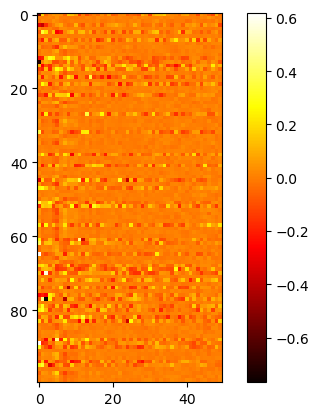

In [124]:
import matplotlib.pyplot as plt
import numpy as np

a = model.encoder.pooler.dense.weight.to('cpu').detach().numpy()
b = principalComponents
heatmap = plt.imshow(X_sparse_tsvd, cmap='hot') #d, 
plt.colorbar(heatmap)
plt.show()

In [108]:
# general svd, take the diagonal for visualization
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.ensemble import RandomForestClassifier

image = a
U, s, V = np.linalg.svd(image)
top_n_eigens = 100
s = s[:top_n_eigens]
d = np.diag(s)
d

array([[4.95, 0.00, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 3.57, 0.00, ..., 0.00, 0.00, 0.00],
       [0.00, 0.00, 3.03, ..., 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, ..., 0.86, 0.00, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.86, 0.00],
       [0.00, 0.00, 0.00, ..., 0.00, 0.00, 0.85]], dtype=float32)

In [123]:
# truncated svd = LSA. Not centred unlike PCA so used for sparse matrices
from sklearn.decomposition import TruncatedSVD
def truncate_2d(matrix):
    tsvd = TruncatedSVD(n_components=50)
    matrix = tsvd.fit(matrix).transform(matrix)
    # matrix = matrix.T
    # matrix = tsvd.fit(matrix).transform(matrix)
    return matrix[:100]
    
X_sparse_tsvd = truncate_2d(a)
X_sparse_tsvd

array([[-0.55, 0.18, -0.05, ..., -0.11, 0.10, -0.03],
       [0.01, 0.00, 0.01, ..., 0.02, -0.01, -0.01],
       [-0.02, 0.02, 0.00, ..., -0.02, 0.02, -0.01],
       ...,
       [-0.06, 0.06, 0.04, ..., 0.00, 0.01, 0.00],
       [-0.01, 0.01, 0.02, ..., 0.02, -0.02, 0.03],
       [-0.02, 0.02, 0.01, ..., -0.01, -0.01, 0.02]], dtype=float32)

evidence
purpose
background
e-elaboration


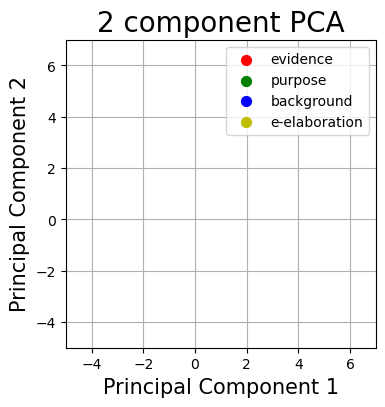

In [80]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series([mnli_dataset.rev_label_dict[x] for x in y.tolist()])], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2', 'target']

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = mnli_dataset.label_dict.keys()
# print(targets)
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    print(target)
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
plt.xlim([-5, 7])
plt.ylim([-5, 7])
ax.grid()

In [24]:
#best val acc
model.load_state_dict(torch.load(save_path_suffix+'_best_latest.pt'))
test_loss, test_acc = validate(model, val_loader, optimizer, rev_label_dict, label_dict)
writer.add_scalar('val_loss_best_latest', test_loss, 1)
writer.add_scalar('val_acc_best_latest', test_acc, 1)
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')
print(f'Val Loss: {test_loss:.3f} |  Val Acc: {test_acc*100:.2f}%')

Test_loss: 2.0303 test_acc: 0.3875
00:00:02.93
                precision    recall  f1-score   support

    antithesis       0.20      0.09      0.13        11
    background       0.32      0.71      0.44        17
         cause       0.00      0.00      0.00         7
  circumstance       0.00      0.00      0.00        13
    concession       0.29      0.36      0.32        11
     condition       0.44      0.88      0.58         8
   conjunction       0.75      0.75      0.75         8
      contrast       0.00      0.00      0.00         3
 e-elaboration       0.73      0.62      0.67        13
   elaboration       0.28      0.29      0.28        28
  evaluation-n       0.00      0.00      0.00         8
  evaluation-s       0.00      0.00      0.00         5
      evidence       0.00      0.00      0.00         8
interpretation       0.20      0.15      0.17        13
         joint       0.24      0.44      0.31        18
          list       0.38      0.61      0.47        18


/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/VD/kaveri/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,